In [1]:
import json
import os

from ost import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, auc, precision_recall_curve
import numpy as np

data_dir = os.path.join("..", "data")
plot_dir = os.path.join("..", "data", "plots")

if not os.path.exists(data_dir):
    raise RuntimeError("You need to give me some data")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
cred = (128.0/255,0.0,0.0)
cblue = (102.0/255,153.0/255,204.0/255)
cgreen = (102.0/255,148.0/255,0.0)
cpurple = (100.0/255,0.0,200.0/255)
corange = (255.0/255,123.0/255,0.0)

# color palette from Jay, originally from https://thenode.biologists.com/data-visualization-with-flying-colors/research/
j_colors = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933', '#CC6677', '#882255', '#AA4499', '#DDDDDD']

# load group mapping
with open("../group_mappings.json", 'r') as fh:
    group_mappings = json.load(fh)
    
# manually add group 248_2
group_mappings["248_2"] = group_mappings["248"] + "_2"


In [2]:
# data loading
df = pd.read_csv("../data/ema_local_scores.csv")

print(df.shape)



# we're loading the list created with "../analysis/extract_epitope_interface_residues.py"
with open("../data/epitope_interface_residues.json", 'r') as fh:
    epitope_interface_residues = json.load(fh)

# let's select only the residues specified in there
ep_int_set = set([x[0] + '_' + x[1] for x in epitope_interface_residues])

# hack for "target_data" dict to only include antibody targets
#with open("../ema_targets.json", 'r') as fh:
#    target_data = json.load(fh)
target_data = {"H1166": "H1166.pdb",
               "H1167": "H1167.pdb",
               "H1168": "H1168.pdb"}
 
#target_data = {"H1168": "H1168.pdb"}
trg_set = set(target_data.values())



selection_array = np.zeros((df.shape[0],), dtype=bool)
for idx in range(df.shape[0]):
    mdl_name = df["mdl"][idx]
    cname = df["cname"][idx]
    rnum = df["rnum"][idx]
    rstring = mdl_name + '_' + cname + '.' + str(rnum) + '.'
    trg = df["trg"][idx]
    if rstring in ep_int_set and trg in trg_set:
        selection_array[idx] = True

df = df[selection_array]
print(df.shape)

    


(3506779, 40)
(25717, 40)


In [3]:
# filter df - kick out models with different stoichiometry as target
# we're just going for chain count here... 
target_structure_dir = "../data/assembly_targets"
n_trg_chains = dict()
for f in os.listdir(target_structure_dir):
    ent = io.LoadPDB(os.path.join(target_structure_dir, f))
    n_trg_chains[f] = len(ent.chains)

df["n_trg_chains"] = [n_trg_chains[trg] for trg in df["trg"]]
df_filtered = df[df["n_mdl_chains"] == df["n_trg_chains"]]

# report kicked out models (T1192 gets kicked out completely, as the target has wrong stoichiometry)
mdls = set(df["mdl"])
filtered_mdls = set(df_filtered["mdl"])
assert(filtered_mdls.issubset(mdls))
kicked_out_mdls = mdls.difference(filtered_mdls)
kicked_out_mdls = sorted(list(kicked_out_mdls))
print(f"kicked out {len(kicked_out_mdls)} models:", kicked_out_mdls)
print(f"total models:", len(mdls))
print(f"remaining models:", len(filtered_mdls))
print(f"n targets:", len(set(df_filtered["trg"])))

df = df_filtered

residue A.CYS109 contains unknown atom OD1
residue A.CYS109 contains unknown atom OD2
residue A.CYS109 contains unknown atom OD3
residue B.CYS109 contains unknown atom OD1
residue B.CYS109 contains unknown atom OD2
residue B.CYS109 contains unknown atom OD3
residue C.CYS109 contains unknown atom OD1
residue C.CYS109 contains unknown atom OD2
residue C.CYS109 contains unknown atom OD3
residue D.CYS109 contains unknown atom OD1
residue D.CYS109 contains unknown atom OD2
residue D.CYS109 contains unknown atom OD3
residue E.CYS109 contains unknown atom OD1
residue E.CYS109 contains unknown atom OD2
residue E.CYS109 contains unknown atom OD3
residue F.CYS109 contains unknown atom OD1
residue F.CYS109 contains unknown atom OD2
residue F.CYS109 contains unknown atom OD3
residue G.CYS109 contains unknown atom OD1
residue G.CYS109 contains unknown atom OD2
residue G.CYS109 contains unknown atom OD3
residue H.CYS109 contains unknown atom OD1
residue H.CYS109 contains unknown atom OD2
residue H.C

kicked out 0 models: []
total models: 876
remaining models: 876
n targets: 3


In [4]:
groups = ['426', '168', '494', '126', '248', '248_2', '266', '083', '282', '120', '468', '101', '234', '245', '002', '098', '298', '041', '158', '398', '121', '089', '169', '365', '283', '275', '086']

In [5]:
# report how many datapoints we have per group
total_data_points = df.shape[0]
print("total datapoints:", total_data_points)
data_points = dict()
for g in groups:
    n = df[df[g].isnull()==False].shape[0]
    print(f"group {g} datapoints: {n}")
    data_points[g] = n
print()
print()
total_per_target_data_points = dict()
per_target_data_points = {g: dict() for g in groups}
for trg, trg_file in target_data.items():
    sub_df = df[df["trg"]==trg_file]
    total_per_target_data_points[trg] = sub_df.shape[0]
    print(f"target {trg} datapoints: {total_per_target_data_points[trg]}")
    for g in groups:
        n = sub_df[sub_df[g].isnull()==False].shape[0]
        per_target_data_points[g][trg] = n
        print(f"group {g} datapoints: {n}")
    print("\n\n")

total datapoints: 25717
group 426 datapoints: 8298
group 168 datapoints: 8298
group 494 datapoints: 21468
group 126 datapoints: 0
group 248 datapoints: 15868
group 248_2 datapoints: 25567
group 266 datapoints: 25717
group 083 datapoints: 25717
group 282 datapoints: 0
group 120 datapoints: 0
group 468 datapoints: 8298
group 101 datapoints: 24106
group 234 datapoints: 0
group 245 datapoints: 25717
group 002 datapoints: 0
group 098 datapoints: 0
group 298 datapoints: 0
group 041 datapoints: 25717
group 158 datapoints: 25290
group 398 datapoints: 0
group 121 datapoints: 21468
group 089 datapoints: 24880
group 169 datapoints: 0
group 365 datapoints: 0
group 283 datapoints: 0
group 275 datapoints: 0
group 086 datapoints: 0


target H1166 datapoints: 9184
group 426 datapoints: 0
group 168 datapoints: 0
group 494 datapoints: 7891
group 126 datapoints: 0
group 248 datapoints: 6092
group 248_2 datapoints: 9135
group 266 datapoints: 9184
group 083 datapoints: 9184
group 282 datapoints: 0
group 12

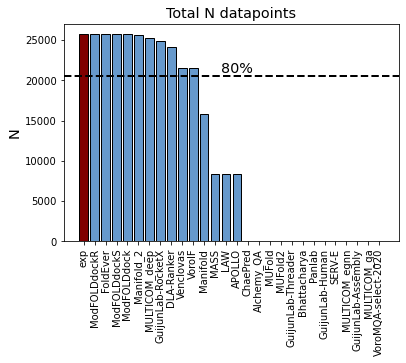

In [6]:
# plot data situation on full datapoints

# the reference...
plt.bar([0], [total_data_points], color=cred, linewidth=1.0, edgecolor='k')

# data from groups
tmp = [(data_points[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*total_data_points, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*total_data_points,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

plt.ylabel("N", fontsize="x-large")
plt.title("Total N datapoints", fontsize="x-large")
plt.xticks([0] + x, ["exp"] + sorted_groups_names, rotation=90)
plt.savefig(os.path.join(plot_dir, "local_data_points_ab.png"), dpi=300, bbox_inches="tight")

groups considered for further evaluation: ['494', '266', '248_2', '245', '158', '121', '101', '089', '083', '041']


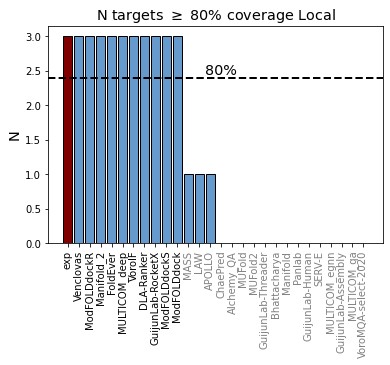

In [7]:
# plot data situation on a per-target basis

# the reference...
N = sum([1 for x in total_per_target_data_points.values() if x > 0])
plt.bar([0], [N], color=cred, linewidth=1.0, edgecolor='k')

# data from groups - count how many targets have > 80% of datapoints
counts = {g: 0 for g in groups}
for g in groups:
    for trg, tot in total_per_target_data_points.items():
        if tot == 0:
            fraction = 0.0 # happens for T1192o
        else:
            fraction = float(per_target_data_points[g][trg])/tot
        if fraction > 0.8:
            counts[g] += 1

tmp = [(counts[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*N, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*N,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

sorted_groups_names = ["exp"] + sorted_groups_names
tick_colors = ['k']
for data_point in sorted_data_points:
    if data_point < 0.8*N:
        tick_colors.append('0.5')
    else:
        tick_colors.append('k')

plt.xticks([0] + x, sorted_groups_names, rotation=90)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)

plt.ylabel("N", fontsize="x-large")
plt.title(r"N targets $\geq$ 80% coverage Local", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, "local_data_points_per_target_ab.png"), dpi=300, bbox_inches="tight")

# And here's what we want for further processing
eval_groups = [g for g,c in zip(sorted_groups, sorted_data_points) if c >= 0.8*N]
print("groups considered for further evaluation:", eval_groups)

In [8]:
# evaluation metrics
def adaptive_rocauc(df, target, pred):
    """ Returns ROC AUC with an adaptive class threshold
    
    Adaptive in a sense that the top quantile according target
    is considered positive.
    """
    thresh = df[target].quantile(0.75)
    sub_df = df[(df[target].isnull() == False) & (df[pred].isnull() == False)]
    target_classes = [int(x>thresh) for x in sub_df[target]]
    return max(0.5, roc_auc_score(target_classes, sub_df[pred]))

def pearson_corr(df, target, pred):
    """ Returns pearson correlation
    """
    return df[target].corr(df[pred], method="pearson")

def spearman_corr(df, target, pred):
    """ Returns spearman correlation
    """
    return df[target].corr(df[pred], method="spearman")

In [9]:
def per_target_eval(df, target, eval_groups,
                    target_data, filter_target, filter_target_thresh,
                    metrics={"pearson_r": pearson_corr,
                             "spearman_r": spearman_corr,
                             "roc_auc": adaptive_rocauc}):
    """ Returns DataFrame with one row per target
    
    For each target, each group is evaluated against specified metrics
    (default: pearson_r, spearman_r, roc_auc)
    
    So let's say you have one target (x) and one group (y), you'll get the 
    following columns: x, y_pearson_r, y_spearman_r, y_roc_auc
    
    :param df: The overall per-model DataFrame
    :type df: :class:`DataFrame`
    :param target: The target value, e.g. lddt, cad, patch_qs, patch_dockq
    :type target: :class:`str`
    :param eval_groups: List of groups that are evaluated (y in example above)
    :type eval_groups: :class:`list` of :class:`str`
    :param target_data: Dictionary used in overall evaluation, i.e. trg name as key
                        and respective target file as value
    :type target_data: :class:`dict`
    :param filter_target: Target value used for filtering, i.e. target will be skipped if 
                          no model has the respective value above *filter_target_thresh*
                          (e.g. tm_score, qs_best, etc.)
    :type filter_target: :class:`str`
    :param filter_target_thresh: Threshold for specified *filter_target*
    :type filter_target_tresh: :class:`float`
    :param metrics: Evaluation metrics... shouldn't be changed...
    :type metrics: :class:`dict`
    """
    data = {"trg": list()}
    for g in eval_groups:
        for m in metrics.keys():
            data[g + "_" + m] = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if sub_df.shape[0] == 0:
            print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df[filter_target].max() < filter_target_thresh:
            print("skip trg", trg)
            continue
        data["trg"].append(trg)
        for g in eval_groups:
            n_exp = sub_df.shape[0]
            n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
            if float(n_pred)/n_exp < 0.8:
                # not enough predictions for g
                for m in metrics.keys():
                    data[g + "_" + m].append(None)
            else:
                for m,f in metrics.items():
                    data[g + "_" + m].append(f(sub_df, target, g))
    return pd.DataFrame.from_dict(data)

def per_group_eval(per_target_df, eval_groups,
                   metrics=["pearson_r", "spearman_r", "roc_auc"]):
    """ Takes per_target evaluation with respect to one target value (e.g. tm_score)
    and returns DataFrame with per group averages
    
    So lets say you have one group x, you'll get a DataFrame with the following columns:
    x, pearson_r, spearman_r, roc_auc where the evaluation metrics represent the
    per-target averages.
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"group": list()}
    for m in metrics:
        data[m] = list()
    for g in eval_groups:
        data["group"].append(g)
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    return pd.DataFrame.from_dict(data)

In [10]:
from scipy.stats import zscore

def get_zscore_df(df, target, eval_groups, target_data):
    per_target_df = per_target_eval(df, target, eval_groups, target_data, "global_qs_best", 0.6)
    per_group_df = per_group_eval(per_target_df, eval_groups)

    z_per_group_df = per_group_df.copy()
    numeric_cols = z_per_group_df.select_dtypes(include=[np.number]).columns
    for nc in numeric_cols:
        z_per_group_df[nc] = zscore(z_per_group_df[nc])

    # don't punish for abysmal performance => set negative z-scores to 0.0
    num = z_per_group_df._get_numeric_data()
    num[num < 0] = 0
    
    return (z_per_group_df, per_group_df, per_target_df)

lddt_z_df, lddt_per_group_df, lddt_per_target_df = get_zscore_df(df, "lddt", eval_groups, target_data)
cad_z_df, cad_per_group_df, cad_per_target_df = get_zscore_df(df, "cad", eval_groups, target_data)
patch_qs_z_df, patch_qs_per_group_df, patch_qs_per_target_df = get_zscore_df(df, "patch_qs", eval_groups, target_data)
patch_dockq_z_df, patch_dockq_per_group_df, patch_dockq_per_target_df = get_zscore_df(df, "patch_dockq", eval_groups, target_data)


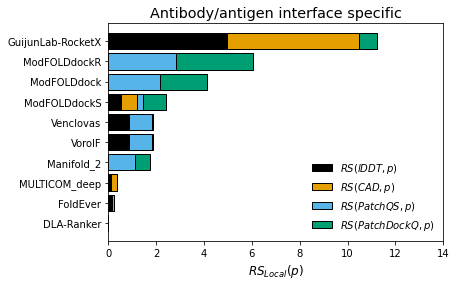

In [11]:
lddt_score = np.array(0.5*lddt_z_df["pearson_r"] + 0.5*lddt_z_df["spearman_r"] + lddt_z_df["roc_auc"])
cad_score = np.array(0.5*cad_z_df["pearson_r"] + 0.5*cad_z_df["spearman_r"] + cad_z_df["roc_auc"])
patch_qs_score = np.array(0.5*patch_qs_z_df["pearson_r"] + 0.5*patch_qs_z_df["spearman_r"] + patch_qs_z_df["roc_auc"])
patch_dockq_score = np.array(0.5*patch_dockq_z_df["pearson_r"] + 0.5*patch_dockq_z_df["spearman_r"] + patch_dockq_z_df["roc_auc"])
groups = list(lddt_z_df["group"])

tmp = [(a+b+c+d,a,b,c,d,e) for a,b,c,d,e in zip(lddt_score, cad_score, patch_qs_score, patch_dockq_score, groups)]
tmp.sort()

sorted_per_target_lddt = [x[1] for x in tmp]
sorted_per_target_cad = [x[2] for x in tmp]
sorted_per_target_patch_qs = [x[3] for x in tmp]
sorted_per_target_patch_dockq = [x[4] for x in tmp]
sorted_per_target_groups = [x[5] for x in tmp]
sorted_per_target_groups_names = [group_mappings[x] for x in sorted_per_target_groups]

# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(len(sorted_per_target_groups)))

# do lDDT
left = [0] * len(sorted_per_target_groups)
plt.barh(y, sorted_per_target_lddt, left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$RS(lDDT, p)$")

# do CAD
left = [a+b for a,b in zip(left, sorted_per_target_lddt)]
plt.barh(y, sorted_per_target_cad, left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$RS(CAD, p)$")

# do PatchQS
left = [a+b for a,b in zip(left, sorted_per_target_cad)]
plt.barh(y, sorted_per_target_patch_qs, left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$RS(PatchQS, p)$")

# do PatchDockQ
left = [a+b for a,b in zip(left, sorted_per_target_patch_qs)]
plt.barh(y, sorted_per_target_patch_dockq, left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$RS(PatchDockQ, p)$")

plt.xlim((0, 14))
plt.title("Antibody/antigen interface specific", fontsize="x-large")
plt.yticks(y, sorted_per_target_groups_names)
plt.xlabel("$RS_{Local}(p)$", fontsize = "large")
plt.legend(frameon=False)
plt.savefig(os.path.join(plot_dir, f"local_zscore_ranking_ab.png"), dpi=300, bbox_inches="tight")


0.2349036539160906


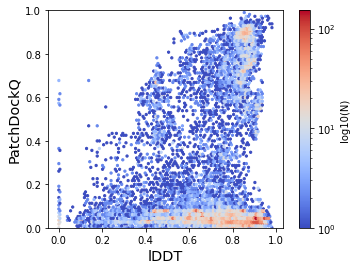

In [12]:
plt.clf()
plt.hexbin('lddt', 'patch_dockq', data=df, bins='log', cmap='coolwarm')
#plt.hexbin('lddt', 'patch_dockq', data=df)
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("lDDT", fontsize="x-large")
plt.ylabel("PatchDockQ", fontsize="x-large")
plt.colorbar(label="log10(N)")
print(df["lddt"].corr(df["patch_dockq"], method="pearson"))
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/lddt_vs_patchdockq_ab.png", dpi=300)


0.9535441290235369


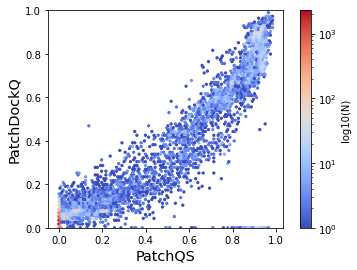

In [13]:
plt.clf()
plt.hexbin('patch_qs', 'patch_dockq', data=df, bins='log', cmap='coolwarm')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("PatchQS", fontsize="x-large")
plt.ylabel("PatchDockQ", fontsize="x-large")
plt.colorbar(label="log10(N)")
print(df["patch_qs"].corr(df["patch_dockq"], method="pearson"))
plt.savefig("/home/schdaude/workspace/casp15_ema/data/plots/patchqs_vs_patchdockq_ab.png", dpi=300)


In [14]:
print("overall ROC AUC")
for g in eval_groups:
    sub_df = df[df[g].isnull()==False]
    print(g, group_mappings[g], roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))

print()
print("avg per target AUC")
for g in eval_groups:
    values = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if n_exp == 0:
            #print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df["global_qs_best"].max() < 0.6:
            #print("skip trg", trg)
            continue
        if float(n_pred)/n_exp >= 0.8:
            sub_df = sub_df[sub_df[g].isnull()==False]
            values.append(roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))
    print(g, group_mappings[g], np.mean(values))
                   

overall ROC AUC
494 Venclovas 0.6214160185889787
266 ModFOLDdockR 0.7396636151774671
248_2 Manifold_2 0.7083244225259758
245 FoldEver 0.5252801244507983
158 MULTICOM_deep 0.4302085253064107
121 VoroIF 0.6214160185889787
101 DLA-Ranker 0.5420007234193922
089 GuijunLab-RocketX 0.639953867998287
083 ModFOLDdockS 0.6934669460643412
041 ModFOLDdock 0.7394899293087954

avg per target AUC
494 Venclovas 0.5948586074957481
266 ModFOLDdockR 0.734680498723518
248_2 Manifold_2 0.6531316564853302
245 FoldEver 0.5559678421854276
158 MULTICOM_deep 0.4234533627974648
121 VoroIF 0.5948586074957481
101 DLA-Ranker 0.5691680311244455
089 GuijunLab-RocketX 0.5624886248306865
083 ModFOLDdockS 0.6647461917871973
041 ModFOLDdock 0.7628344405753501


[0.5948586074957481, 'Venclovas']
[0.734680498723518, 'ModFOLDdockR']
[0.6531316564853302, 'Manifold_2']
[0.5559678421854276, 'FoldEver']
[0.4234533627974648, 'MULTICOM_deep']
[0.5948586074957481, 'VoroIF']
[0.5691680311244455, 'DLA-Ranker']
[0.5624886248306865, 'GuijunLab-RocketX']
[0.6647461917871973, 'ModFOLDdockS']
[0.7628344405753501, 'ModFOLDdock']
[0.4234533627974648, 'MULTICOM_deep']
[0.5559678421854276, 'FoldEver']
[0.5624886248306865, 'GuijunLab-RocketX']
[0.5691680311244455, 'DLA-Ranker']
[0.5948586074957481, 'Venclovas']
[0.5948586074957481, 'VoroIF']
[0.6531316564853302, 'Manifold_2']
[0.6647461917871973, 'ModFOLDdockS']
[0.734680498723518, 'ModFOLDdockR']
[0.7628344405753501, 'ModFOLDdock']


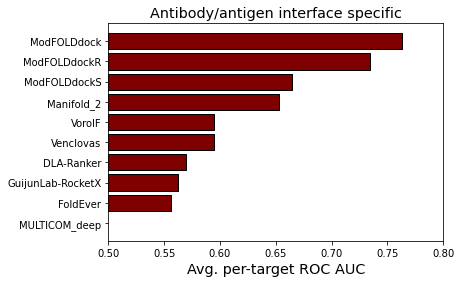

In [15]:
# do ROC AUC of interface probability plot

data = list()

for g in eval_groups:
    values = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g].isnull()==False].shape[0]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if n_exp == 0:
            #print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max QS-score of any of the models > 0.6
        if sub_df["global_qs_best"].max() < 0.6:
            #print("skip trg", trg)
            continue
        if float(n_pred)/n_exp >= 0.8:
            sub_df = sub_df[sub_df[g].isnull()==False]
            values.append(roc_auc_score(sub_df["true_interface_residue"], sub_df[g]))
            #precision, recall, thresholds = precision_recall_curve(sub_df["true_interface_residue"], sub_df[g])
            #values.append(auc(recall, precision))
            #print(group_mappings[g], trg, sub_df[sub_df["true_interface_residue"]==0].shape[0],sub_df[sub_df["true_interface_residue"]==1].shape[0])
    data.append([np.mean(values), group_mappings[g]])
    print(data[-1])
    

data.sort()

for item in data:
    print(item)

y = list(range(len(data)))
labels = [x[1] for x in data]

plt.barh(y, [x[0] for x in data], color=cred, linewidth=1.0, edgecolor='k')
plt.yticks(y, labels)

plt.xlim((0.5, 0.80))

plt.title("Antibody/antigen interface specific", fontsize="x-large")
plt.xlabel("Avg. per-target ROC AUC", fontsize="x-large")

plt.savefig(os.path.join(plot_dir, f"local_interface_probability_analysis_ab.png"), dpi=300, bbox_inches="tight")

In [97]:
for trg, trg_file in target_data.items():

    sub_df = df[df["trg"] == trg_file]
    # per-target evaluation only assesses targets which fulfill very crude
    # quality filter, e.g. max QS-score of any of the models > 0.6
    if sub_df["global_qs_best"].max() < 0.6:
        #print("skip trg", trg)
        continue

    sub_df = sub_df[sub_df[g].isnull()==False]
    print(trg)
    print("True values:", sub_df[sub_df["true_interface_residue"]==1].shape[0])
    print("False values:", sub_df[sub_df["true_interface_residue"]==0].shape[0])
    print()

H1168
True values: 6509
False values: 2739



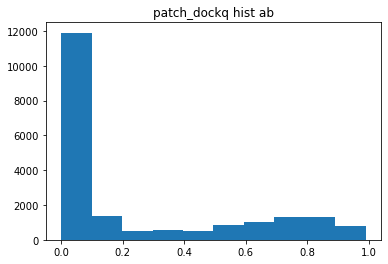

In [126]:
#sub_df = df[df["trg"]=="H1168.pdb"]
sub_df = df


plt.clf()
plt.hist(sub_df["patch_dockq"])
plt.title("patch_dockq hist ab")
plt.savefig(os.path.join(plot_dir, f"patch_dockq_hist_ab.png"), dpi=300, bbox_inches="tight")